In [7]:
#import statements
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

# Problem 1

**Note: need to run cell for problem 2 before this one, since it has the integrator!**

Electric field of a spherical shell of radius R. There is a singularity where z=R, since the denominator of the solution has a |z-R| term. 

First I use scipy's integrate.quad, which doesn't entirely blow up from the singularity, but it tries to plot what seems to be an intermediate point (see first plot), which isn't correct.


I use the adaptive step recursive integrator from problem 2 - note that I added an `args` parameter to pass variables that are constant under integration, in this case, z and r. 

My numerical integrator gets stuck when z = R and doesn't keeps running without any output (I try printing out the integral solutions and it doesn't ever evaluate it). To avoid the numerical integrator crashing at z = R, I get the function to output an error before integrating if z == r and set the integral at that point to nan. 

See below for plot of E vs. r for both the numerical integrator and scipy's quad integrator.

Error: cannot evaluate integral at r = z. Skipping this point


Text(0.5, 1.0, 'Evaluating at z=R (only scipy.quad)')

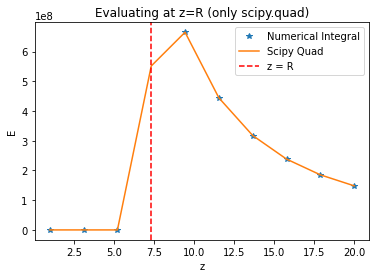

In [49]:
def integrand(theta,z,R):
    return ((z-(R*np.cos(theta))*np.sin(theta))/(((R**2)+(z**2)-(2*R*z*np.cos(theta)))**(3/2)))

def integrand_u(u,z,R):
    return coeff*((z-R*u)/((R**2)+(z**2)-(2*R*z*u))**(3/2))

#parameters
eps = 8.854e-12 #SI units
sigma = 5.6704e-8 #SI units
dist = np.linspace(1,20,10) #array of z values
R = dist[3]

coeff = (2*np.pi*(R**2)*sigma)/(4*np.pi*eps)

#store integrated values for each z in an array
vals_sp = np.array(())
vals_mine = np.array(())

for z in dist:
    z=float(z)
    
    #evaluate scipy integrals
    y_sp,err_sp = integrate.quad(integrand_u,-1,1,args=(z,R))
    vals_sp = np.append(vals_sp,coeff*y_sp)

    if z == R:
        print('Error: cannot evaluate integral at r = z. Skipping this point')
        vals_mine = np.append(vals_mine,np.nan)
        continue
    
    #evaluate integral numerically
    y_mine = integrate_adaptive(integrand_u,-1,1,1e-5,args=(z,R),extra=None)
    vals_mine = np.append(vals_mine,coeff*y_mine)
    
    if z == R:
        print(f'Electric field calculated by scipy at z == R: {y_sp}')
        
plt.plot(dist,vals_mine,'*',label='Numerical Integral')
plt.plot(dist,vals_sp,'-',label='Scipy Quad')
plt.xlabel('z')
plt.ylabel('E')
plt.axvline(R,ls='--',color='r',label='z = R')
plt.legend()
plt.title('Evaluating at z=R (only scipy.quad)')

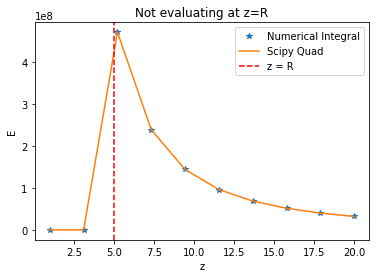

In [47]:
def integrand(theta,z,R):
    return ((z-(R*np.cos(theta))*np.sin(theta))/(((R**2)+(z**2)-(2*R*z*np.cos(theta)))**(3/2)))

def integrand_u(u,z,R):
    return coeff*((z-R*u)/((R**2)+(z**2)-(2*R*z*u))**(3/2))

#parameters
eps = 8.854e-12 #SI units
sigma = 5.6704e-8 #SI units
dist = np.linspace(1,20,10) #array of z values
R = 5

coeff = (2*np.pi*(R**2)*sigma)/(4*np.pi*eps)

#store integrated values for each z in an array
vals_sp = np.array(())
vals_mine = np.array(())

for z in dist:
    z=float(z)
    
    #evaluate scipy integrals
    y_sp,err_sp = integrate.quad(integrand_u,-1,1,args=(z,R))
    vals_sp = np.append(vals_sp,coeff*y_sp)

    if z == R:
        print('Error: cannot evaluate integral at r = z. Skipping this point')
        vals_mine = np.append(vals_mine,np.nan)
        continue
    
    #evaluate integral numerically
    y_mine = integrate_adaptive(integrand_u,-1,1,1e-5,args=(z,R),extra=None)
    vals_mine = np.append(vals_mine,coeff*y_mine)
    
    if z == R:
        print(f'Electric field calculated by scipy at z == R: {y_sp}')
        
plt.plot(dist,vals_mine,'*',label='Numerical Integral')
plt.plot(dist,vals_sp,'-',label='Scipy Quad')
plt.xlabel('z')
plt.ylabel('E')
plt.axvline(R,ls='--',color='r',label='z = R')
plt.title('Not evaluating at z=R')
plt.legend()

# Problem 2

`integrate_adaptive` is a recursive 3 point integral adapted from Jon's integrate_adaptive_class.py. This calculates the integral at 5 points and then looks at 5 points in each half of the region, recursively. 

Note that the args parameter is so that this can be used for functions with non-integration variables

Since we are using 5 points, when we divide the interval in half, on the right the first, second, and third points correspond to the first, middle, and endpoint of the new interval (similarly done with x=2,3,4 for RHS interval). This means we don't need to call `fun(x)` for x = 0,3,5 but can pass along the values in the `extra` array from the values called by f(x) in the previous call. This means we only need to call f(x) for 2/5 points.

`lazy int` is exactly the integrator seen in class (integrate_adaptive_class.py).

`integrate_adaptive` has 5 initial f(x) calls and 2 calls for each additional call `lazy_int` has 5 calls every time. I don't see a super easy way to count the number of calls for the function, so I have it print out 'called adaptive' or 'called lazy' every time each recursive function is called (this should be the same number of total calls), and count the number of called things. Then I calculate the total number of f(x) calls with $n_{f(x)} = 5 + 2(calls-1)$. For `lazy_int`, we can just use $n_{f(x)} = 5*calls$.

See below that there are far fewer calls (< 50%) for the adaptive method than the lazy method, when tested on $f(x) = e^x$ and $f(x) = cos(x)$.

In [2]:
def integrate_adaptive(fun,a,b,tol,args=None,extra=None):
    #print('called adaptive')
    x=np.linspace(a,b,5)
    dx=x[1]-x[0]
    y = np.empty([len(x)])
    
    if args:
        if extra == None:
            y[0] = fun(x[0],*args)
            y[1] = fun(x[1],*args)
            y[2] = fun(x[2],*args)
            y[3] = fun(x[3],*args)
            y[4] = fun(x[4],*args)

        else:
            y[0] = extra[0]
            y[1] = fun(x[1],*args)
            y[2] = extra[1]
            y[3] = fun(x[3],*args)
            y[4] = extra[2]
            
    else:
        if extra == None:
            y[0] = fun(x[0])
            y[1] = fun(x[1])
            y[2] = fun(x[2])
            y[3] = fun(x[3])
            y[4] = fun(x[4])

        else:
            y[0] = extra[0]
            y[1] = fun(x[1])
            y[2] = extra[1]
            y[3] = fun(x[3])
            y[4] = extra[2]
        
    
    #do the 3-point integral
    i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
    i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
    myerr=np.abs(i1-i2)
    
    #pass the previous fun(x) calls to the next function call, extra1 for LHS and extra2 for RHS
    extra1=[y[0],y[1],y[2]]
    extra2=[y[2],y[3],y[4]]
    
    if myerr<tol:
        return i2
    else:
        mid=(a+b)/2
        int1=integrate_adaptive(fun,a,mid,tol/2,args,extra=extra1)
        int2=integrate_adaptive(fun,mid,b,tol/2,args,extra=extra2)
        return int1+int2

def lazy_int(fun,a,b,tol):
    #print('called lazy')
    x=np.linspace(a,b,5)
    dx=x[1]-x[0]
    y=fun(x)
    #do the 3-point integral
    i1=(y[0]+4*y[2]+y[4])/3*(2*dx)
    i2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/3*dx
    myerr=np.abs(i1-i2)
    if myerr<tol:
        return i2
    else:
        mid=(a+b)/2
        int1=lazy_int(fun,a,mid,tol/2)
        int2=lazy_int(fun,mid,b,tol/2)
        return int1+int2

### Test for $f(x) = e^x$

In [254]:
integ = integrate_adaptive(np.exp,1,2,1e-10,args=None,extra=None)
integ2 = lazy_int(np.exp,1,2,1e-10)

actual = np.exp(2)-np.exp(1)
print(f'My result is {integ} for adaptive, actual analytical value should be {actual}.\nError on my integrator: {actual-integ}')

My result is 4.670774270474942 for adaptive, actual analytical value should be 4.670774270471606.
Error on my integrator: -3.3359981443936704e-12


In [58]:
calls = 173
fun_calls_adaptive = 5 + 2*(calls-1)
fun_calls_lazy = 5*(calls-1)

print(f'# f(x) calls for adaptive method: {fun_calls_adaptive}')
print(f'# f(x) calls for lazy method: {fun_calls_lazy}')
print(f'{fun_calls_lazy-fun_calls_adaptive} fewer calls for adaptive method')

# f(x) calls for adaptive method: 349
# f(x) calls for lazy method: 860
511 fewer calls for adaptive method


### Test for $f(x) = cos(x)$

In [256]:
integ = integrate_adaptive(np.cos,1,2,1e-10,extra=None)
integ2 = lazy_int(np.cos,1,2,1e-10)

actual = np.sin(2)-np.sin(1)
print(f'My result is {integ} for adaptive, actual analytical value should be {actual}.\nError on my integrator: {actual-integ}')

My result is 0.06782644201778128 for adaptive, actual analytical value should be 0.0678264420177852.
Error on my integrator: 3.927413949611491e-15


In [62]:
calls = 85
fun_calls_adaptive = 5 + 2*(calls-1)
fun_calls_lazy = 5*(calls-1)

print(f'# f(x) calls for adaptive method: {fun_calls_adaptive}')
print(f'# f(x) calls for lazy method: {fun_calls_lazy}')
print(f'{fun_calls_lazy-fun_calls_adaptive} fewer calls for adaptive method')

# f(x) calls for adaptive method: 173
# f(x) calls for lazy method: 420
247 fewer calls for adaptive method


# Problem 3

In [51]:
x = np.linspace(0.5,1,1001)
y = np.log2(x)

### Chebyshev fit to get coefficients

I use a high order fit here 30th degree - this seems to be roughly what gives the best accuracy with errors $\approx 10^{14}$ (see residuals plot). Very high orders ~100 tend to blow up at the ends when we truncate the Chebyshev polynomials, so keep it to high but reasonable order

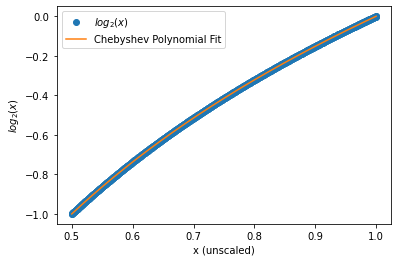

Text(0.5, 1.0, 'Residuals')

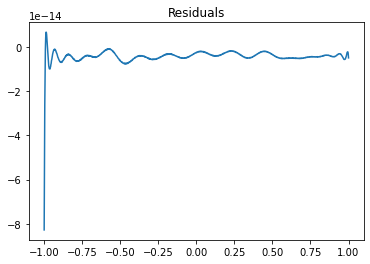

In [54]:
x_reshaped=np.linspace(-1,1,1001)

order = 30

cheb_coeff = np.polynomial.chebyshev.chebfit(x_reshaped,y,order) #calculates chebyshev coefficients
chebs = np.polynomial.chebyshev.chebval(x_reshaped,cheb_coeff) #evaluates chebyshev polynomials * coeff at each x

plt.plot(x,y,'o',label=r'$log_2(x)$')
plt.plot(x,chebs,label='Chebyshev Polynomial Fit')
plt.xlabel('x (unscaled)')
plt.ylabel('$log_2(x)$')
plt.legend()
plt.show()

plt.plot(x_reshaped,y-chebs)
plt.title('Residuals')

### Translation between x and reshaped x

The x and reshaped x values have the linear relation $x_{cheby} = ax_{data} + b$. We know endpoints for $x_{cheby}$ are -1 and 1 and $x_{data}$ are 0.5 and 1.

I don't know understand how to do this so I am leaving it like this. I just used a generic -1 to 1 linspace to fit the Chebyshev polynomials, but I can't get the final result because I need to scale the value I am interpolating from the Chebyshev fit first. The code still seems to give me a very reasonable output though

The linear fit is something like the equation below:

In [ ]:
x_cheby = ax_data + b

### Truncate the Chebyshev coefficients to keep only the terms that are needed for a good fit

We want errors of order < $10^{-6}$, so for a 30th order fit, we need to keep the first 8 terms (see residuals plot)

6.000176682768287


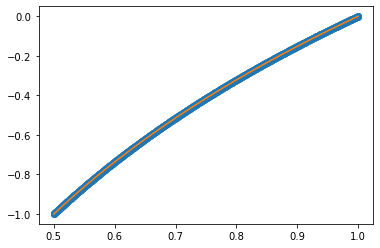

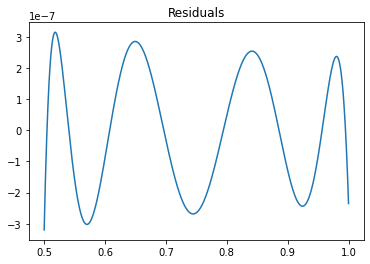

In [23]:
terms = 8

cheb_coeff[terms:] = 0
chebs = np.polynomial.chebyshev.chebval(x_reshaped,cheb_coeff)
print(np.polynomial.chebyshev.chebval(5,cheb_coeff))

#plot again to make sure nothing weird happened after truncation
plt.plot(x,y,'o')
plt.plot(x,chebs)
plt.show()

plt.title('Residuals')
plt.plot(x,y-chebs)

### Estimate $ln(n)$ from $log_2(n)$

Computers represent numbers in 32 bits as $-1(S) * M * 2^E$, where S is the sign, M is the mantissa, and E is the exponent.  

This means we can decompose n into mantissa and exponent with `np.frexp` such that $n = M * 2^E$. So we can take the ln of both sides to get $ln(n) = ln(m) + Eln(2)$. 

To evaluate $ln(m)$, we expand $ln(1+x), x=m-1 $ in a Taylor series, since m ~ 1, so a Taylor series approximation should work. To evaluate $Eln(2)$, we use the relation $ln(2) = \frac{ln(m)}{log_2(m)}$ and use our previous result for $ln(m)$. We can get $log_2(m)$ from evaluating the Chebyshev interpolation above at $x = m$.

Since we have scaled $x$ to be between -1 and 1 for the Chebyshev fit, we need to find the value in this scale that corresponds to $x_{unscaled} = m$.

In [57]:
def taylor_expand(x,order):
    expansion = 0
    for i in range(1,order+1):
        expansion = expansion + (((x-1)/(x+1))**(2*i-1))/(2*i-1)
    return 2*expansion
        
def mylog2(n):
    
    k = 10 #related to tolerance s.t. absolute tolerance is 2**(-k)
    
    #decompose n into mantissa and exponent
    man,exp = np.frexp(n)
    
    #evaluate ln(m) to k terms
    ln_m = taylor_expand(man,k)
    
    #evaluate ln(2)
    man_rescaled = 4*man-3
    ln_2 = ln_m / (np.polynomial.chebyshev.chebval(man_rescaled,cheb_coeff))
    
    ln_n = ln_m + exp*ln_2
    return ln_n

In [60]:
print(f'My ln(7): {mylog2(7)}')
print(f'Actual ln(7): {np.log(7)}')
print(f'Error: {np.log(7)-mylog2(7)}')

My ln(7): 1.9459101490553505
Actual ln(7): 1.9459101490553132
Error: -3.730349362740526e-14
